In [1]:
import os
import ipywidgets as widgets
import glob
import re
from pathlib import Path



class FileBrowser(object):
    """ Implements an ipywidgets file chooser.
    >>> f = FileBrowser
    >>> f.widget() # activate the widget
    >>> ...
    >>> f.path # get the selected file...
    """

    def __init__(self):
        self.path = str(Path.home())
        self._update_files()

    def _update_files(self):
        self.files = list()
        self.dirs = list()
        if os.path.isdir(self.path):
            for f in os.listdir(self.path):
                ff = self.path + "/" + f
                if os.path.isdir(ff) and f[0] != '.':
                    self.dirs.append(f)
                else:
                    if not f.startswith((".", "$", "~")):
                        self.files.append(f)

    def widget(self):
        box = widgets.VBox()
        self._update(box)
        return box

    def _update(self, box):

        def on_click(b):
            if b.description == 'up one level':
                self.path = os.path.split(self.path)[0]
            else:
                self.path = self.path + "/" + b.description
            self._update_files()
            self._update(box)

        buttons = []
        # if self.files:
        button = widgets.Button(description='up one level', background_color='#aaaaaa')
        button.on_click(on_click)
        buttons.append(button)
        for f in sorted(self.dirs):
            button = widgets.Button(description=f)
            button.style.button_color = 'lightgreen'
            button.on_click(on_click)
            buttons.append(button)
        for f in sorted(self.files):
            button = widgets.Button(description=f, background_color='#ff0000')
            button.style.button_color = 'lightblue'
            button.on_click(on_click)
            buttons.append(button)
        box.children = tuple([widgets.HTML("You have selected: %s" % (self.path,))] + buttons)



In [567]:
from skimage import io
from skimage import color
from skimage import measure
from scipy import ndimage as ndi
import redspot
import matplotlib.pyplot as plt
import numpy as np
from skimage import feature
from typing import Callable, List, Tuple, Union

LEAF_AREA_HUE = tuple([i / 255 for i in(0, 255)])
LEAF_AREA_SAT = tuple([i / 255 for i in(50, 255)])
LEAF_AREA_VAL = tuple([i / 255 for i in(40, 255)])

HEALTHY_HUE = tuple([i / 255 for i in(40, 255)])
HEALTHY_SAT = tuple([i / 255 for i in(50, 255)])
HEALTHY_VAL = tuple([i / 255 for i in(0, 255)])

HEALTHY_RED = (4,155)
HEALTHY_GREEN = (120,175)
HEALTHY_BLUE = (0,255)

LESION_HUE = tuple([i / 255 for i in(0, 35)])
LESION_SAT = tuple([i / 255 for i in(0, 255)])
LESION_VAL = tuple([i / 255 for i in(5, 185)])


def threshold_hsv_img(im: np.ndarray, 
                      h: Tuple[float,float] = HEALTHY_HUE, 
                      s: Tuple[float,float] = HEALTHY_SAT, 
                      v: Tuple[float,float] = HEALTHY_VAL) -> np.ndarray:
    """returns a logical binary mask array (dtype bool_ of dimension im ( an HSV image) in which pixels in im pass the lower
    and upper thresholds specified in h, s and v (hue lower,upper; sat lower,upper and val lower, upper;
    respectively) """
    assert im.dtype.type is np.float64, "im must be np.ndarray of type float64. Looks like you're not using an HSV image."
    return _threshold_three_channels(im, c1_limits = h, c2_limits = s, c3_limits = v)


def hsv_to_rgb255(img) -> np.ndarray:
    """given an hsv image in (0.0,1.0) scale, converts to RGB image in (0,255)"""
    return (color.hsv2rgb(img) * 255).astype('int')


def threshold_rgb_img(im: np.ndarray, 
                      r: Tuple[int,int] = HEALTHY_RED, 
                      g: Tuple[int,int] = HEALTHY_GREEN, 
                      b: Tuple[int,int] = HEALTHY_BLUE) -> np.ndarray:
    """returns a logical binary mask array (dtype bool_ of dimension im ( an RGB image) in which pixels in im pass the lower
    and upper thresholds specified in r, g and b (red lower,upper; green lower,upper and blue lower, upper;
    respectively) """
    assert im.dtype.type is np.int64, "im must be np.ndarray of type int in scale (0,255). Looks like you're not using a RGB image in range (0,255)."
    return _threshold_three_channels(im, c1_limits = r, c2_limits = g, c3_limits = b)


def _threshold_three_channels(im: np.ndarray, 
                              c1_limits: Tuple[Union[int,float],Union[int,float]] = (0,1), 
                              c2_limits: Tuple[Union[int,float],Union[int,float]] = (0,1),
                              c3_limits: Tuple[Union[int,float],Union[int,float]] = (0,1)
                             ) -> np.ndarray:
    """returns a logical binary mask array (dtype bool_ of dimension im  in which pixels in im pass the lower
    and upper thresholds specified in c1_limits, c2_limits and c3_limits respectively) """
    
    c1 = im[:, :, 0]
    c2 = im[:, :, 1]
    c3 = im[:, :, 2]
    
    c1_min,c1_max = c1_limits
    c2_min,c2_max = c2_limits
    c3_min,c3_max = c3_limits

    
    c1_mask = np.logical_and(
        c1 >= c1_min, c1 <= c1_max
    )
    c2_mask = np.logical_and(
        c2 >= c2_min, c2 <= c2_max
    )
    c3_mask = np.logical_and(
        c3 >= c3_min, c3 <= c3_max
    )
    return np.logical_and(c1_mask, c2_mask, c3_mask)


def load_as_hsv(fname: str) -> np.ndarray:
    hsv_img: np.ndarray
    """takes a file path and opens the image then converts to HSV colour space. 
    returns numpy array dtype float 64"""
    img = io.imread(fname)
    hsv_img = color.rgb2hsv(img)
    return hsv_img


def preview_mask(m: np.ndarray, width: int = 10, height: int = 5) -> None:
    """given a binary bool mask array returns a plot in two colours black = 1/True, white = 0/False"""
    plt.figure(figsize=(width, height))
    plt.imshow(m, cmap="binary_r")
    plt.show()


def preview_object_labels(label_array: np.ndarray, binary_image: np.ndarray) -> None:
    """given a labelled array from ndi.label and a background binary image, returns a plot with
    the objects described in the labelled array coloured in. For preview purposes not further analysis """
    overlay = label2rgb(label_array, image = binary_image, bg_label = 0)
    plt.imshow(overlay)
    plt.show()


def is_long_and_large(obj: measure._regionprops._RegionProperties, major_to_minor: int = 2, min_area: int = 300 * 300) -> List:
    """"given a region props object works ; returns True if the object represented has a
     major to minor axis ratio of > major_to_minor and takes up pixels of min_area,
     False otherwise and None if not calculable"""
    try:
        ratio = obj.major_axis_length / obj.minor_axis_length
        if ratio  >= major_to_minor and obj.area >= min_area:
            return True
        else:
            return False
    except ZeroDivisionError:
        return None
    
    
def is_not_small(obj: measure._regionprops._RegionProperties, min_area: int = 50 * 50) -> List:
    """"given a region props object ; returns True if takes up pixels of min_area,
     False otherwise and None if not calculable"""
    try:
        if obj.area >= min_area:
            return True
        else:
            return False
    except:
        return None



def label_image(m: np.ndarray, structure = None, output = None) -> Tuple[np.ndarray, int]:
    """given a binary mask array, returns a version with the distinct islands labelled by integers,
    and a count of objects found. Thin wrapper around ndi.label """
    label_array: np.ndarray
    number_of_labels: int

    label_array, number_of_labels = ndi.label(m,structure, output)
    return label_array, number_of_labels


def get_object_properties(label_array: np.ndarray) -> List[measure._regionprops._RegionProperties]:
    """given a label array returns a list of computed RegionProperties objects."""
    return measure.regionprops(label_array, coordinates='xy' )


def filter_region_property_list(region_props: List[measure._regionprops._RegionProperties],
                            func: Callable[[measure._regionprops._RegionProperties], bool] ) \
        -> List[measure._regionprops._RegionProperties]:
    """given a list of region props, and a function that returns True/False for each region prop
     Returns a list of region props that have passed"""
    return [r for r in region_props if func(r)]


def clean_labelled_mask(label_array: np.ndarray, region_props: List[measure._regionprops._RegionProperties]) -> np.ndarray:
    """given a label array, sets the labels not represented in region_props to Zero - effectively removing them from the image. Intended to be used on label images"""
    labels_to_keep: list = [r.label for r in region_props]
    keep_mask = np.isin(label_array, labels_to_keep)
    return label_array * keep_mask


def extract_image_segment(hsv_img: np.ndarray, region_prop: measure._regionprops._RegionProperties) -> np.ndarray:
    """given 3D hsv_img returns a slice covered by the bounding box of region_prop"""
    min_row,min_col,max_row,max_col = region_prop.bbox
    return hsv_img[min_row:max_row,min_col:max_col]


def griffiths_healthy_regions(hsv_img: np.ndarray, 
                      h: Tuple[float,float] = HEALTHY_HUE, 
                      s: Tuple[float,float] = HEALTHY_SAT, 
                      v: Tuple[float,float] = HEALTHY_VAL ) -> Tuple[np.ndarray, int]:
    """given an image in hsv applies Ciaran Griffiths detection for healthy regions.
    returns the mask of pixels and the pixel volume. Note does not convert to RGB - not clear 
    at this time whether whether that code actually does anything in Ciaran's script."""
    #TO DO: check with Ciaran whether the RGB change here is actually effective?! 
    #rgb_img = hsv_to_rgb255(hsv_img)
    mask = threshold_hsv_img(hsv_img).astype(int)#,r,g,b)
    filled_mask = ndi.binary_fill_holes(mask)
    
    return (filled_mask, np.sum(mask))


def griffiths_lesion_regions(hsv_img, h: Tuple[float,float] = LESION_HUE, s: Tuple[float,float] = LESION_SAT, v: Tuple[float,float] = LESION_VAL, sigma: float = 2.0) -> Tuple[np.ndarray, int]:
    """given an image in hsv applies Ciaran Griffiths detection for lesion regions.
    applies a hsv_space colour threshold, then finds edges with Canny and fills that mask for holes.
    returns a labelled mask of objects and the object count."""
    mask = threshold_hsv_img(hsv_img, h = h, s = s, v = v).astype(int)
    #edges = feature.canny(mask, sigma=sigma).astype(int)
    lesion_mask = ndi.binary_fill_holes(mask)
    return lesion_mask, np.sum(mask)

def griffiths_leaf_regions(hsv_img, h: Tuple[float,float] = LEAF_AREA_HUE, s: Tuple[float,float] = LEAF_AREA_SAT, v: Tuple[float,float] = LEAF_AREA_VAL) -> Tuple[np.ndarray, int]:
    """given an image in hsv applies Ciaran Griffiths detection for leaf area regions.
    applies a hsv_space colour threshold and fills that mask for holes.
    returns a binary mask object count."""
    mask = threshold_hsv_img(hsv_img, h = h, s = s, v = v).astype(int)
    return ndi.binary_fill_holes(mask)
    

def clear_background(img: np.ndarray, mask: np.ndarray) -> np.ndarray:
    """given an image and a binary mask, clears all pixels in the image (ie sets to zero)
    the zero/false pixels in the mask"""
    i = img.copy()
    a = i[:,:,0] * mask
    b = i[:,:,1] * mask
    c = i[:,:,2] * mask
    return np.dstack([a,b,c])

## Loading an image

Loading the test image is straightforward. First we create a `FileBrowser object` and navigate to the file we want to use

In [431]:
f = FileBrowser()
f.widget()

The file path of the file we selected is in the `f.path` attribute. We now pass that to the `redspot.load_as_hsv()` function, which loads the image into an HSV colour space. 


In [ ]:
hsv_image = load_as_hsv( f.path )

We can preview the HSV image by sending an RGB version to the `scikit.color.hsv2rgb()` function and the RGB version result to the `scikit.io.imshow()`. Note we don't save the RGB version anywhere, and we don't convert the HSV image `hsv_image` permanently, it's just done for the preview. Our working image remains in `hsv_image` in HSV colour space

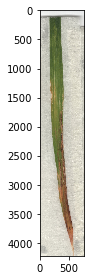

In [437]:
io.imshow(color.hsv2rgb(hsv_image) )
io.show()

## Finding the leaf

To find the pixels of the leaf, we can use the Griffiths HSV threshold method encapsulated in the function `redspot.griffiths_leaf_region()`. We pass `hsv_image` to run it with default values. The values can be changed, as we'll see later. This function returns a mask - an array of the same dimensions as the image that contains True/False values that state whether a pixel is in the image.

We can print it directly, or look at as an image using `redspot.preview_mask()`. White pixels are those `True` ones that `redspot.griffiths_leaf_regions()` believes belong in the leaf


(0.0, 1.0) (0.19607843137254902, 1.0) (0.1568627450980392, 1.0)


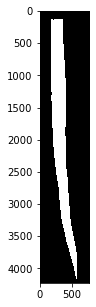

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [500]:
leaf_area_mask = griffiths_leaf_regions(hsv_image)
preview_mask(leaf_area_mask)
leaf_area_mask

## Finding objects in a mask

The next step is to see how many objects are in this mask. This is conceptualised as regions of `True`s in the mask that are disconnected from other `True`, islands of `True`s in effect. 

We first label each island, converting all the `True`s in the first island to the digit `1`, all the `Trues` in the second island to `2` and so on. This is done with the `redspot.label_image()` function. It returns a new mask where islands have numeric labels and the background has zeroes, and a count of the objects found.



In [553]:
labelled_leaf_area, leaf_areas_found = label_image(leaf_area_mask)

27

We can preview the objects using the `redspot.preview_object_labels()` function, which takes a label mask and a background image, here we'll use the `leaf_area_mask` we created above.

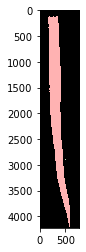

In [554]:
preview_object_labels(labelled_leaf_area, leaf_area_mask)

Looks good! Looks like we found one big leaf object. Let's check that by cross referencing with the number of objects reported... 

In [568]:
leaf_areas_found

27

Not good. We actually found 27 objects. The huge main one and lots of ones that are so small they don't render in the preview. This is a consequence of having such a straightforward object call. We can get rid of the small ones by calculating the objects sizes and filtering.

### Removing noise in the background

We can get the properties of objects with the `redspot.get_object_properties()` on the labelled image. This returns a list of `RegionProps` code objects that describe many features of the objects.   

In [ ]:
leaf_area_properties = get_object_properties(labelled_leaf_area)

We can then work out which of those to keep. We can filter a list of RegionProps using the `redspot.filter_region_property()` function and a filter function. The second argument `redspot.is_not_small` filters out all objects smaller than 50 by 50 pixels. 

After this we have one RegionProp left

In [555]:
leaf_areas_to_keep = filter_region_property_list(leaf_area_properties, is_not_small)
len(leaf_areas_to_keep)

1

Hopefully it's the leaf area. We  remove the labels from the label mask `labelled_leaf_area` that don't appear in our list of RegionProps to keep with `redspot.clean_labelled_mask()`. 

We can preview the result with `redspot.preview_object_labels()`. 

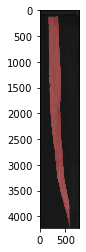

In [563]:
cleaned_leaf_area = clean_labelled_mask(labelled_leaf_area, leaf_areas_to_keep)
preview_object_labels(cleaned_leaf_area, hsv_image)


Great! Looks like we got the leaf on its own with no other objects.

## Extracting the leaf from the background

Once we have a leaf mask we can use it to extract the pixels matching it from the background. A slight problem is that our `cleaned_leaf_area` isn't a `True/False` mask (or its numeric equivalent a `1/0` mask), its a zero and any other integer mask - because the labelling process converted all the `1`s in islands to other numbers. We can use this idiom to set the pixels with non-zero values back to 1.

In [ ]:
cleaned_leaf_area[cleaned_leaf_area > 0 ] = 1

And now we can use the `redspot.clear_background()` function to creat a new `cleared_image` that contains only leaf pixels.

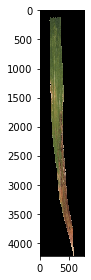

In [566]:
cleared_image = clear_background(hsv_image, cleaned_leaf_area)
io.imshow(color.hsv2rgb(cleared_image))
io.show()

## Finding the healthy regions in the leaf

With a cleaned leaf image we can extract the healthy regions using Griffiths HSV method for the healthy regions, again we have the function `redspot.griffiths_healthy_regions()` for this, with default HSV settings. This function returns a mask of the healthy pixels and the `volume`, basically the number of those pixels. 

We can preview the region found.

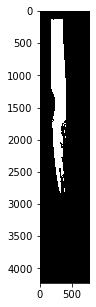

In [513]:
healthy_mask, healthy_volume = griffiths_healthy_regions(cleared_image)
preview_mask(healthy_mask)

An assumption here is that we only really care about the total amount of healthy tissue, and not how many areas of it there are and how big the healthy areas are. If we did care about such things we would need to treat the region slightly differently, more like the lesion areas.

## Finding the lesions

We can find lesions in a similar way, here we use the `redspot.griffiths_lesion_regions()` function to find the lesion areas with some custom `h`,`s` and `v` values.

(0.0, 0.1607843137254902) (0.14901960784313725, 1.0) (0.43529411764705883, 1.0)


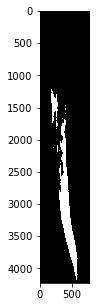

In [514]:
lesion_mask, lesion_volume = griffiths_lesion_regions(cleared_image, h =(0/255, 41/255), s = (38/255, 255/255), v = (111/255, 255/255))
preview_mask(lesion_mask)

With that mask, we can go through the island labelling and object counting as before

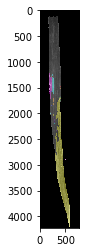

In [543]:
labelled_lesions, lesion_count = label_image(lesion_mask)
preview_object_labels(labelled_lesions, color.hsv2rgb(cleared_image))

In [544]:
lesion_count

542

### Filtering lesion areas

Looks like we found an awful lot of lesions. We can filter these as before by generating the object property list and checking that 

In [545]:
lesion_properties_list = get_object_properties(labelled_lesions)

In [546]:
lesion_regions_to_keep = filter_region_property_list(lesion_properties_list, is_not_small)

In [547]:
len(lesion_regions_to_keep)

3

Great, that left us with a sane three lesion objects. Now We can clean up the object list and the label mask, and preview to make sure we got the right objects

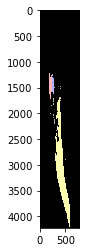

In [548]:
cleaned_labelled_lesions = clean_labelled_mask(labelled_lesions, lesion_regions_to_keep)
preview_object_labels(cleaned_labelled_lesions, lesion_mask)

## Reporting lesion information

The `lesion_regions_to_keep` list is made up of RegionProps objects for each lesion. 

In [571]:
lesion_regions_to_keep

We can use these object to report on the lesion size and other properties

In [572]:
lesion = lesion_regions_to_keep[0]

lesion.area

19653

In [576]:
lesion.label

14

In [577]:
lesion.major_axis_length

531.212336298275